# PARAMETER IDENTIFICATION NOTEBOOK

In this notebook we leverage the pretrained surrogate models to identify the generating transmissivity fiels.\
We start from noisy signals. The noise is an additive white noise, manually added to the data to emulate experimental data. 

##### Importing necessary libraries

In [1]:
# Standard library imports
import sys

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import arviz as az
import timeit
import scipy.stats as stats
from keras.models import Sequential
from keras.layers import Dense, Concatenate
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model

#Try with TinyDA
import tinyDA as tda
from scipy.stats import multivariate_normal
from scipy.stats import uniform


# Local module imports
sys.path.append('./src/SurrogateModeling')
sys.path.append('./src/InverseProblems')
sys.path.append('./src/utils')
from utils import * 
from plotting import *
from random_process import *


2024-07-14 19:16:37.559851: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Ray module not found. Multiprocessing features are not available


#### Decide sample to use for experimental data

In [2]:
sample = 111 # Which sample of the training set do wou want to take as experimental input?
OUTPUT_FILENAME = "./samples/sample_coarse_"+str(sample)

#### Set Bayesian Identification Parameters

In [3]:

# Noise Configuration
NOISE_PARAMS = {
    'noise_factor': 1e-6 * 1000,
    'B': np.sqrt(1000),
    'S': 1,
}

#noise = (NOISE_PARAMS['noise_factor']*NOISE_PARAMS['B']*NOISE_PARAMS['S'])**2
noise = 0.001
noise


0.001

#### Load Surrogate Models

In [5]:
# Extract test data for visualization or further processing
n_eig = 64
X_values = np.loadtxt('./data/X_test.csv', delimiter = ',')
y_values = np.loadtxt('./data/y_test.csv',delimiter = ',')

In [7]:
def set_model(name):
    model = Sequential()
    if(name == '64_sigmoid_old'):
        model.add(Dense(n_eig, input_shape=(n_eig,), activation='sigmoid'))
        model.add(Dense(25, activation='sigmoid'))
        model = load_model('./models/model_NN.keras')
    elif( name == '32_sigmoid'):
        model.add(Dense(n_eig, input_shape=(n_eig,), activation='sigmoid'))
        model.add(Dense(32, activation='sigmoid'))
        model.add(Dense(25, activation='linear'))    
        model = load_model('./models/model_NN_32.keras')   
    elif( name == '64_sigmoid'):
        model.add(Dense(n_eig, input_shape=(n_eig,), activation='sigmoid'))
        model.add(Dense(64, activation='sigmoid'))
        model.add(Dense(32, activation='sigmoid'))
        model.add(Dense(25, activation='linear'))
        model = load_model('./models/model_NN_64_sigmoid.keras')
    elif( name == '64_sigmoid3'):
        model.add(Dense(n_eig, input_shape=(n_eig,), activation='sigmoid'))
        model.add(Dense(128, activation='sigmoid'))
        model.add(Dense(128, activation='sigmoid'))
        model.add(Dense(25, activation='exponential'))
        model = load_model('./models/model_NN_64_sigmoid3.keras')
    elif( name == '16_1'):
        model.add(Dense(n_eig, input_shape=(n_eig,), activation='sigmoid'))
        model.add(Dense(20, activation='sigmoid'))
        model.add(Dense(20, activation='sigmoid'))
        model.add(Dense(25, activation='linear'))
        model = load_model('./models/model_NN_16_1.keras')
    
    return model



In [8]:
# Initialize the neural network model
model_lf = set_model('64_sigmoid3')


/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
def model_nn (input):
    return np.array(model_lf(input.reshape((1,n_eig)))).reshape(25)

### Define a custom Uniform random variable class

In [11]:
# Select a true sample for testing
x_true, y_true = X_values[sample], y_values[sample]
# Generate observed data by adding Gaussian noise to the true data
y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0])

# Define the prior distribution for the input parameters
# Assuming uniform distributions over specified ranges for each parameter
#x_distribution = CustomUniform(-5*np.ones(64), 5*np.ones(64))
# prior distribution
x_distribution = stats.multivariate_normal(mean = np.zeros(n_eig), cov = np.eye(n_eig))

# Pass the sampled input to the forward model
# set the likelihood
cov_likelihood = noise * np.eye(25)
y_distribution = tda.GaussianLogLike(y_observed, cov_likelihood)  

#### Perform least square optimization for each starting point

In [12]:
# Initialize a list to hold the optimized parameters for each start point
initial_guesses = []

# Display the true parameters for reference
print("Real Params: ", x_true)

bounds = (-3*np.ones(n_eig), 3*np.ones(n_eig))

# Iterate over each parameter start point to perform optimizatio
# Perform least squares optimization given the observed data, forward model,
# start point, and parameter bounds
optimized_params, covariance_matrix = least_squares_optimization(
        y_observed=y_observed, 
        forward_model=model_nn , 
        start_point=np.zeros(n_eig), 
        bounds=bounds
    )

# Append the optimized parameters to the list of initial guesses
initial_guesses.append(optimized_params)

# Print the optimized parameters for this iteration
print(f"Optimized Params : {optimized_params}")


Real Params:  [ 6.07650264e-01 -8.78402244e-01  4.06663556e-04 -1.86166846e-01
 -2.97918469e-03 -4.48376340e-03 -1.22163996e-01 -2.37819638e+00
 -1.26224397e+00  1.50821057e+00  1.02839589e+00 -1.15895316e+00
  5.46821352e-01 -6.44307210e-01  1.02496769e+00  3.77303262e-01
 -1.68004872e+00 -8.36349426e-01 -5.79371048e-01  3.63959512e-01
  1.47578306e+00 -6.88356705e-01  6.47310114e-01 -1.61210316e+00
 -1.26842480e+00 -9.79458675e-01 -2.60914875e-01  6.39481321e-01
 -1.00221754e+00  1.28199025e+00  2.82918339e-01  8.02258582e-01
 -1.45885147e+00 -1.33381279e-01  1.30187464e+00  1.30172503e+00
 -6.34388912e-02  9.64635983e-02  4.28349512e-01 -1.69327233e+00
 -4.65579891e-01  5.07873211e-01 -4.08237773e-01 -5.87403509e-01
  1.03857666e+00  9.68174169e-01 -1.52847938e+00 -5.09519078e-01
  3.80445164e-01  9.76485640e-01  1.08563060e+00 -2.30176926e-02
  1.07633620e+00 -9.25089483e-01 -5.48907702e-01  7.27433450e-01
  2.61003812e-01 -2.35570489e-01 -1.08913931e+00  7.35836205e-01
 -5.8881470

#### Do Metropolis Hastings Sampling

Set the parameters for the algorithm 

In [18]:
scaling = 0.15
n_iter = 55000
burnin = 5000
thin = 50

In [19]:
#cov = np.diag(np.linspace(1,5,n_eig))
cov = np.eye(n_eig)

In [20]:
# initialise the LinkFactory
my_posterior = tda.Posterior(x_distribution, y_distribution, model_nn)
# random walk Metropolis
#my_proposal = tda.GaussianRandomWalk(C=cov, scaling= scaling)
my_proposal = tda.CrankNicolson(scaling=scaling, adaptive=False, gamma = 1.01, period=100)
#my_proposal = tda.AdaptiveMetropolis(C0=np.eye(n_eig), sd = 0.2)


In [21]:
# Initialize a list to hold the Markov chain samples for each initial guess
samples_mh = []
ESS_values = []

# Iterate over each initial guess to set up and run the Markov chain sampler
start_0 = timeit.default_timer() 
for index, initial_guess in enumerate(initial_guesses):
    samples = tda.sample(my_posterior, my_proposal, iterations=n_iter, n_chains=1, initial_parameters=initial_guess)
    idata = tda.to_inference_data(samples, level='fine')
    # Remove the burnin and sub-sample
    idata = idata.sel(draw=slice(burnin, None, thin), groups="posterior")
    # Append the samples to the list
    samples_mh.append(idata)
    ess = az.ess(idata)
    # Compute and print the Effective Sample Size (ESS) of the first set of samples
    print("Effective Sample Size: ", ess,"\n\n\n")
end_0 = timeit.default_timer() 

# Computing diagnostics and collecting results
#print("\nRhat: ", az.rhat(az.concat(samples_mh, dim = 'chain')))

#print('Mean ESS:' , np.mean(ESS_values, axis = 0))
#print('Time/ESS MDA',(end_0-start_0)/(5*np.mean(ESS_values, axis = 0)) )


Sampling chain 1/1


Running chain, α = 0.38: 100%|██████████| 55000/55000 [05:06<00:00, 179.63it/s]


Effective Sample Size:  <xarray.Dataset> Size: 512B
Dimensions:  ()
Data variables: (12/64)
    x0       float64 8B 111.3
    x1       float64 8B 92.69
    x2       float64 8B 75.25
    x3       float64 8B 241.0
    x4       float64 8B 91.33
    x5       float64 8B 104.7
    ...       ...
    x58      float64 8B 126.7
    x59      float64 8B 55.92
    x60      float64 8B 116.9
    x61      float64 8B 62.09
    x62      float64 8B 64.48
    x63      float64 8B 105.1 





/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Let's look at the trace plot of one chain

# Diagnostics 

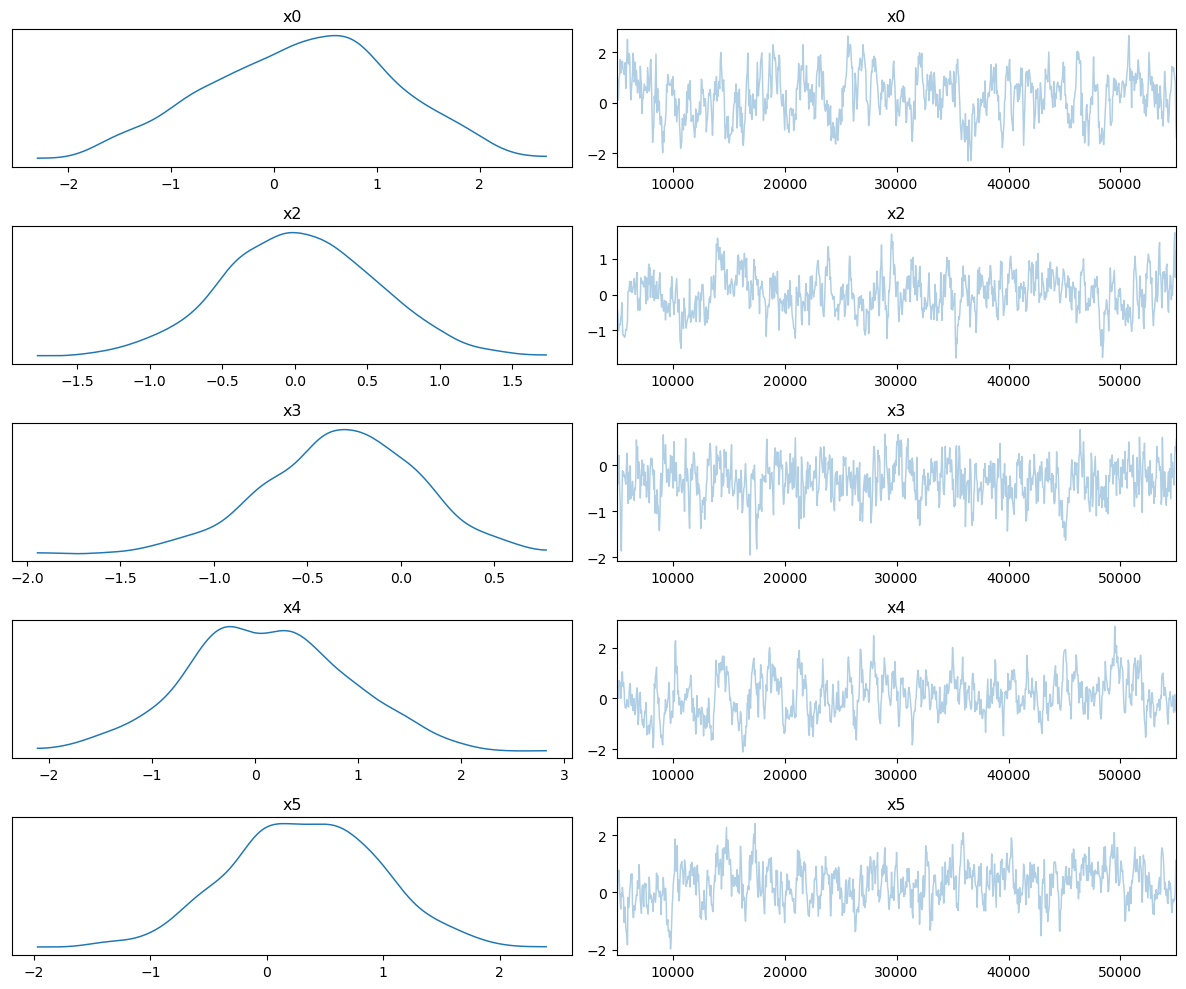

In [22]:
# Plot trace of the first set of samples
az.plot_trace(idata, var_names=['x0', 'x2', 'x3','x4','x5'])
plt.tight_layout()
plt.show()


Let's compare the prediction of the mean parameter combination and the experimental signal

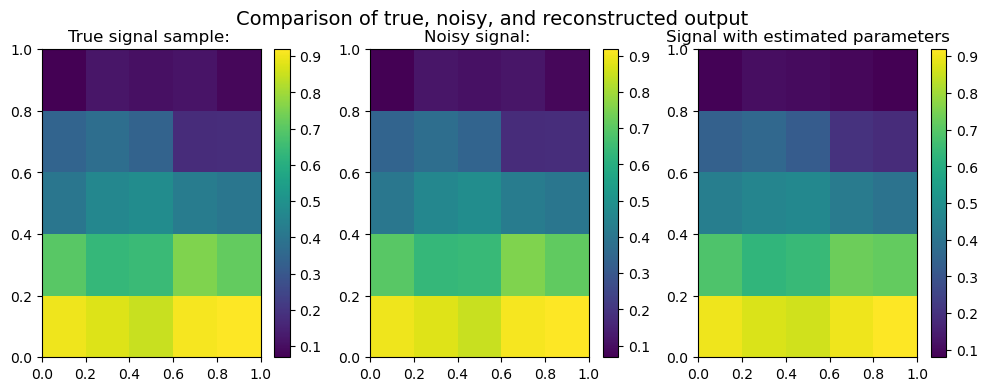

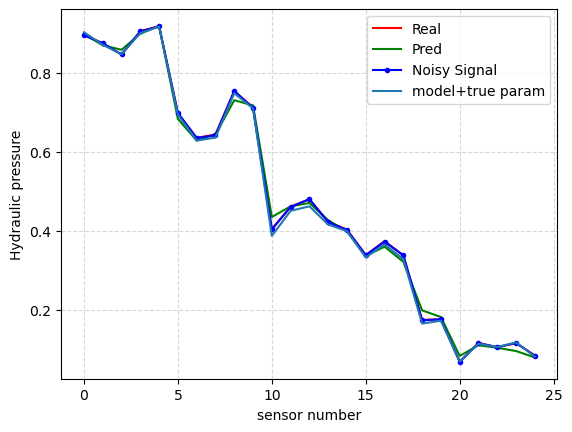

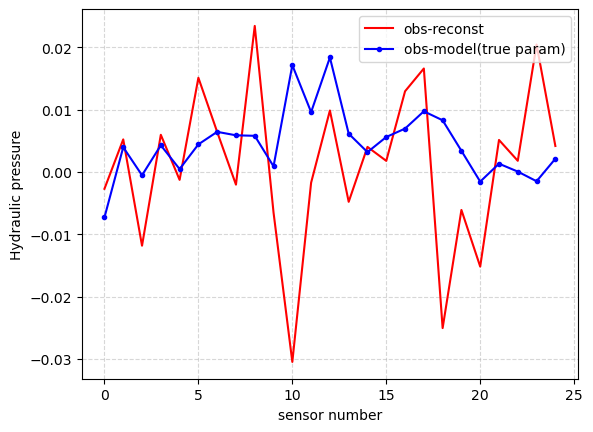

In [23]:
# Plotting and data collection
data = tda.get_samples(samples)['chain_0'][burnin:n_iter:thin, :]
plot_results( y_true, y_observed, model_nn, data, n_eig,x_true)

Finally, let's look at the parameters distribution

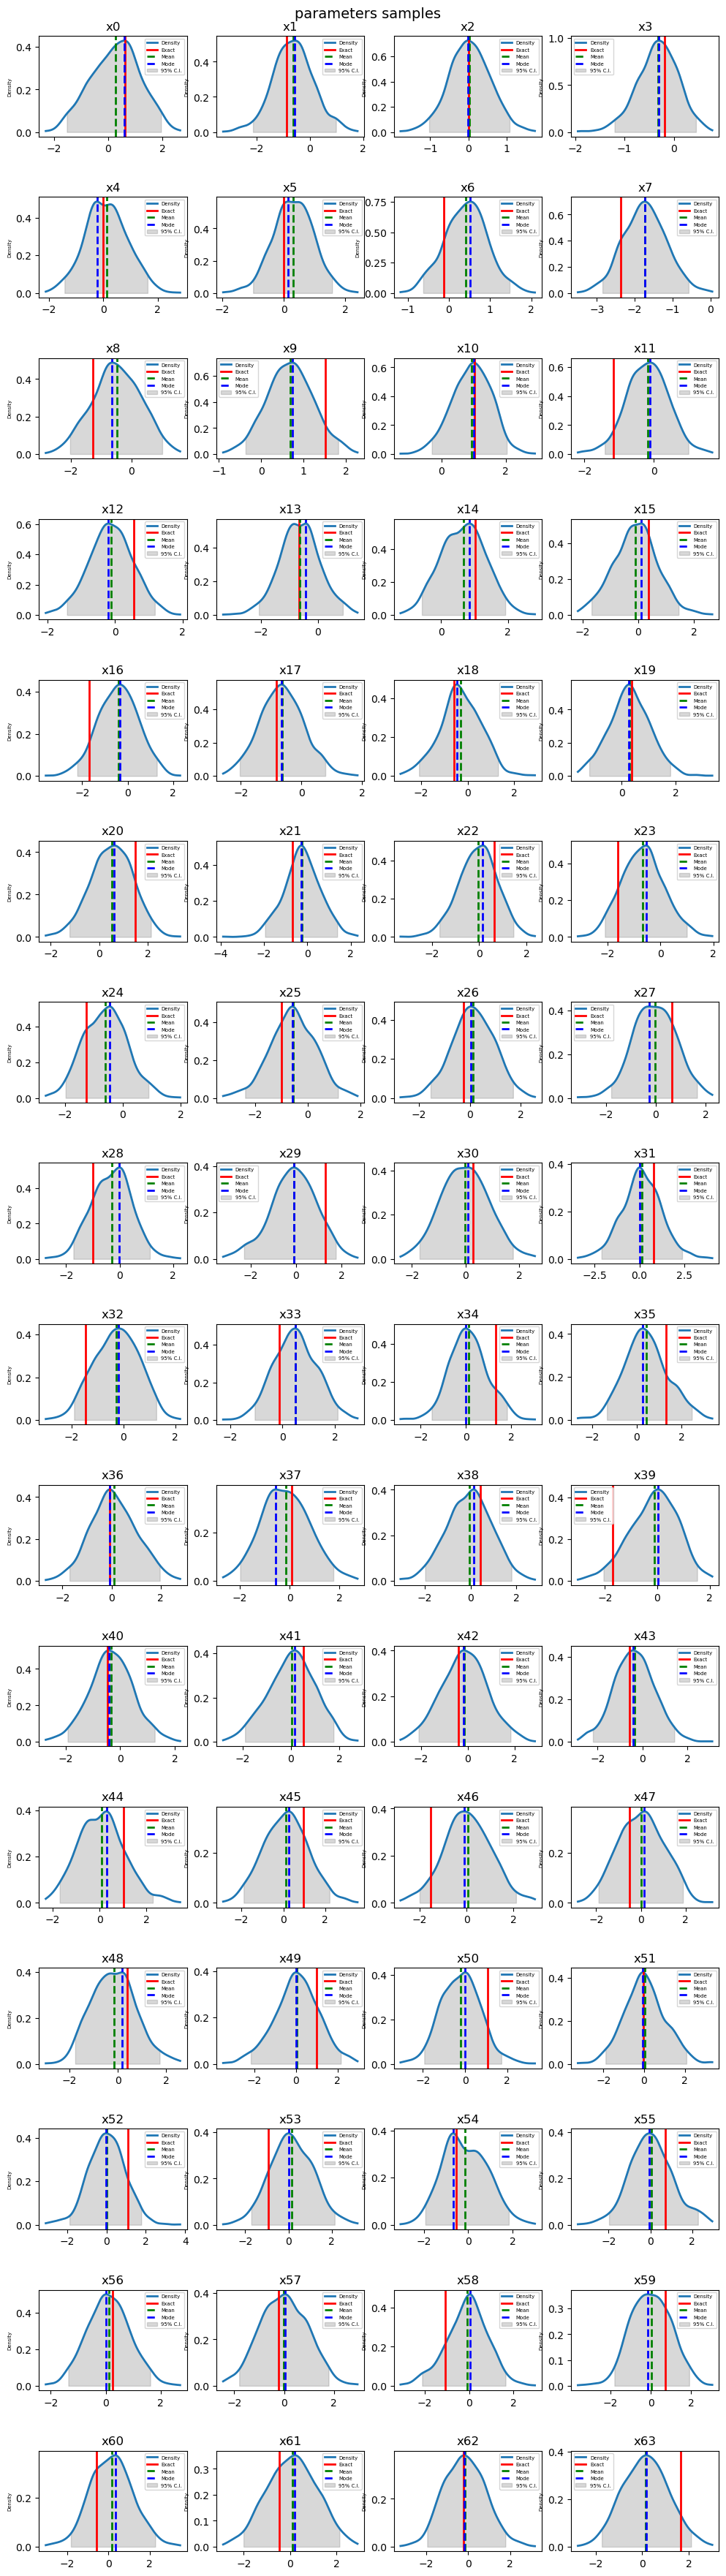

In [24]:
keys = ['x'+ str(i) for i in range(64)]
plot_parameter_distributions(data, x_true, keys, n_eig) 

### Reconstructed field 

<Figure size 1000x400 with 0 Axes>

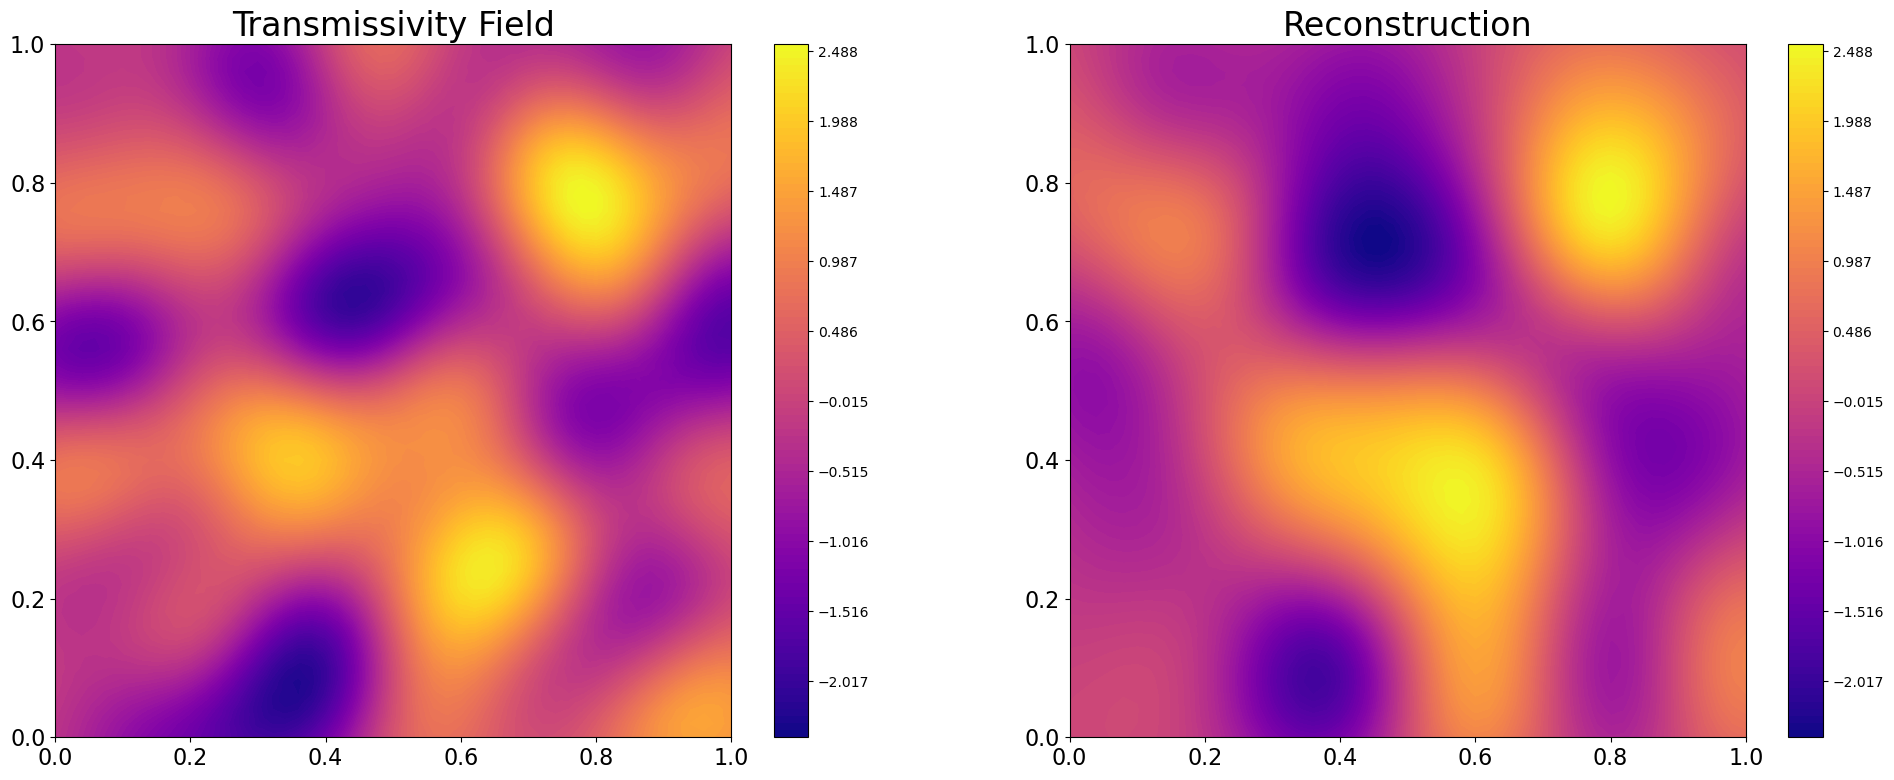

In [27]:
plot_fields(x_true=x_true, x_estimated=2*data.mean(axis=0),n_eig=n_eig, lognormal=False)

# STOP HERE FOR NOW


In [22]:
M = np.zeros((len(subsampling_rate_values), len(scaling_values)))


for index1, ssr in enumerate(subsampling_rate_values):
    for index2, scale in enumerate(scaling_values): 
        # Adaptive Metropolis
        my_proposal = tda.GaussianRandomWalk(C=covariance_matrix, scaling= scale)
        # Initialize a list to hold the Effective sample sizes for each initial guess
        ESS_values = []
        # Iterate over each initial guess to set up and run the Markov chain sampler
        for index, initial_guess in enumerate(initial_guesses[0:2]):
            samples = tda.sample(my_posteriors, my_proposal, 
                         iterations=4000, n_chains=1,
                           initial_parameters=initial_guess, 
                           subsampling_rate = ssr)
                           #adaptive_error_model='state-independent')
            idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])
            # Remove the burnin and sub-sample
            idata = idata.sel(draw=slice(250, None, 5), groups="posterior")
            ess = az.ess(idata)
            ESS_values.append((ess['Overetch'].values + ess['Offset'].values + ess['Thickness'].values)/3)
            if(index==1):
                print('sampled with params: ', ssr, scale, '   done ', index2+1 + index1*len(scaling_values), '/', len(scaling_values)*len(subsampling_rate_values))

        # Add the mean of the different sample sizes to the matrix
        M[index1, index2] = np.mean(ESS_values)

NameError: name 'subsampling_rate_values' is not defined

# Check

Now i want to see what is the mse of the recontruction through the true paramters and the mean that we have found 

In [ ]:
print('The true parameters are:', x_true)
x_estimated = np.mean(data, axis = 1)
print('The estimated params are:', x_estimated)

print('\n\nMSE with true parameters:', ((y_true - model_lf(x_true))**2).sum()/150 ) 
print('MSE with estim parameters:', ((y_true - model_lf(x_estimated))**2).sum()/150 ) 

print('\n\nMSE with true parameters, and data obs:', ((y_observed - model_lf(x_true))**2).sum()/150)
print('MSE with estim parameters and data obs:', ((y_observed - model_lf(x_estimated))**2).sum()/150 ) 


The true parameters are: [ 6.07650264e-01 -8.78402244e-01  4.06663556e-04 -1.86166846e-01
 -2.97918469e-03 -4.48376340e-03 -1.22163996e-01 -2.37819638e+00
 -1.26224397e+00  1.50821057e+00  1.02839589e+00 -1.15895316e+00
  5.46821352e-01 -6.44307210e-01  1.02496769e+00  3.77303262e-01
 -1.68004872e+00 -8.36349426e-01 -5.79371048e-01  3.63959512e-01
  1.47578306e+00 -6.88356705e-01  6.47310114e-01 -1.61210316e+00
 -1.26842480e+00 -9.79458675e-01 -2.60914875e-01  6.39481321e-01
 -1.00221754e+00  1.28199025e+00  2.82918339e-01  8.02258582e-01
 -1.45885147e+00 -1.33381279e-01  1.30187464e+00  1.30172503e+00
 -6.34388912e-02  9.64635983e-02  4.28349512e-01 -1.69327233e+00
 -4.65579891e-01  5.07873211e-01 -4.08237773e-01 -5.87403509e-01
  1.03857666e+00  9.68174169e-01 -1.52847938e+00 -5.09519078e-01
  3.80445164e-01  9.76485640e-01  1.08563060e+00 -2.30176926e-02
  1.07633620e+00 -9.25089483e-01 -5.48907702e-01  7.27433450e-01
  2.61003812e-01 -2.35570489e-01 -1.08913931e+00  7.35836205e-01


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input [ 6.07650280e-01 -8.78402233e-01  4.06663545e-04 -1.86166853e-01
 -2.97918473e-03 -4.48376359e-03 -1.22163996e-01 -2.37819648e+00
 -1.26224399e+00  1.50821054e+00  1.02839589e+00 -1.15895319e+00
  5.46821356e-01 -6.44307196e-01  1.02496767e+00  3.77303272e-01
 -1.68004870e+00 -8.36349428e-01 -5.79371035e-01  3.63959521e-01
  1.47578311e+00 -6.88356698e-01  6.47310138e-01 -1.61210310e+00
 -1.26842475e+00 -9.79458690e-01 -2.60914862e-01  6.39481306e-01
 -1.00221753e+00  1.28199029e+00  2.82918334e-01  8.02258611e-01
 -1.45885146e+00 -1.33381277e-01  1.30187464e+00  1.30172503e+00
 -6.34388924e-02  9.64635983e-02  4.28349525e-01 -1.69327235e+00
 -4.65579897e-01  5.07873237e-01 -4.08237785e-01 -5.87403536e-01
  1.03857660e+00  9.68174160e-01 -1.52847934e+00 -5.09519100e-01
  3.80445153e-01  9.76485670e-01  1.08563066e+00 -2.30176933e-02
  1.07633615e+00 -9.25089478e-01 -5.48907697e-01  7.27433443e-01
  2.61003822e-01 -2.35570490e-01 -1.08913934e+00  7.35836208e-01
 -5.88814676e-01 -4.66385752e-01 -2.01218173e-01  1.66565526e+00]. Expected shape (None, 64), but input has incompatible shape (64,)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(64,), dtype=float32)
  • training=None
  • mask=None

# See performance for 10 samples 

In [ ]:
n = 10
random_samples = [ 125,  60,  53,  89,   9,  61, 156,  99,  92, 115] #np.random.choice(np.arange(160), size=n, replace=False)
print('The extracted samples are: ', random_samples)

samples_box = []

for s in random_samples:
    # Select a true sample for testing
    x_true, y_true = X_values[s], y_values[s]
    print(x_true)
    # Generate observed data by adding Gaussian noise to the true data
    y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0]) 
    # set the likelihood
    y_distribution = tda.GaussianLogLike(y_observed, cov_likelihood*10) 
    
    # Perform least squares optimization given the observed data, forward model,
    # start point, and parameter bounds
    init_guess, cov_matrix = least_squares_optimization(
        y_observed=y_observed, 
        forward_model=model_lf , 
        start_point=np.array([0.2, 0.25, 30.0]), 
        bounds=MCMC_SETTINGS['bounds']
    )
    # initialise the LinkFactory
    my_posterior = tda.Posterior(x_distribution, y_distribution, model_lf )
    # random walk Metropolis
    my_proposal = tda.GaussianRandomWalk(C=cov_matrix, scaling= 0.3) 

    # Perform the MH Algorithm 
    samples = tda.sample(my_posterior, my_proposal, iterations=MCMC_SETTINGS['N'], n_chains=1, initial_parameters=init_guess)
    idata = tda.to_inference_data(samples, level='fine', parameter_names= ['Overetch', 'Offset', 'Thickness'])
    # Remove the burnin and sub-sample
    idata = idata.sel(draw=slice(MCMC_SETTINGS['Nb'], None, MCMC_SETTINGS['Nt']), groups="posterior")
    # Append the samples to the list
    samples_box.append( [idata.posterior['Overetch'].values[0], idata.posterior['Offset'].values[0], idata.posterior['Thickness'].values[0] ])
    
print(samples_box[0][0])


The extracted samples are:  [125  60  53  89   9  61 156  99  92 115]
[ 0.164034  0.281502 30.758818]
Sampling chain 1/1


Running chain, α = 1.00:   0%|          | 0/6000 [00:00<?, ?it/s]

Running chain, α = 0.17: 100%|██████████| 6000/6000 [00:09<00:00, 622.46it/s]
/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/arviz/data/inference_data.py:146: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


[ 0.464787 -0.34692  29.295773]
Sampling chain 1/1


Running chain, α = 0.28: 100%|██████████| 6000/6000 [00:09<00:00, 643.72it/s]


[ 0.391841  0.24583  29.104798]
Sampling chain 1/1


Running chain, α = 0.22: 100%|██████████| 6000/6000 [00:09<00:00, 647.89it/s]


[ 0.381797  0.116394 29.238688]
Sampling chain 1/1


Running chain, α = 0.23: 100%|██████████| 6000/6000 [00:09<00:00, 653.70it/s]


[ 0.417828 -0.33801  29.213157]
Sampling chain 1/1


Running chain, α = 0.23: 100%|██████████| 6000/6000 [00:09<00:00, 636.29it/s]


[ 0.18104   0.097916 29.566415]
Sampling chain 1/1


Running chain, α = 0.24: 100%|██████████| 6000/6000 [00:09<00:00, 663.39it/s]


[ 0.339759  0.329625 29.711193]
Sampling chain 1/1


Running chain, α = 0.28: 100%|██████████| 6000/6000 [00:09<00:00, 661.56it/s]


[ 0.478572 -0.036052 30.60058 ]
Sampling chain 1/1


Running chain, α = 0.22: 100%|██████████| 6000/6000 [00:09<00:00, 609.18it/s]


[ 0.270542  0.352424 30.628894]
Sampling chain 1/1


Running chain, α = 0.18: 100%|██████████| 6000/6000 [00:09<00:00, 651.84it/s]


[ 0.493409  0.207659 30.163214]
Sampling chain 1/1


Running chain, α = 0.22: 100%|██████████| 6000/6000 [00:09<00:00, 662.11it/s]


[0.16338917 0.16374568 0.16432237 ... 0.164202   0.16501121 0.16595848]


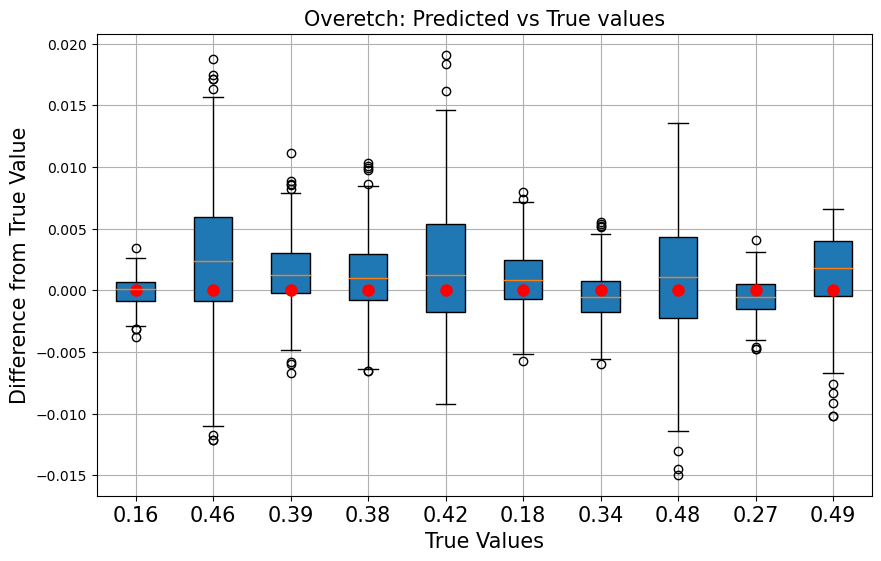

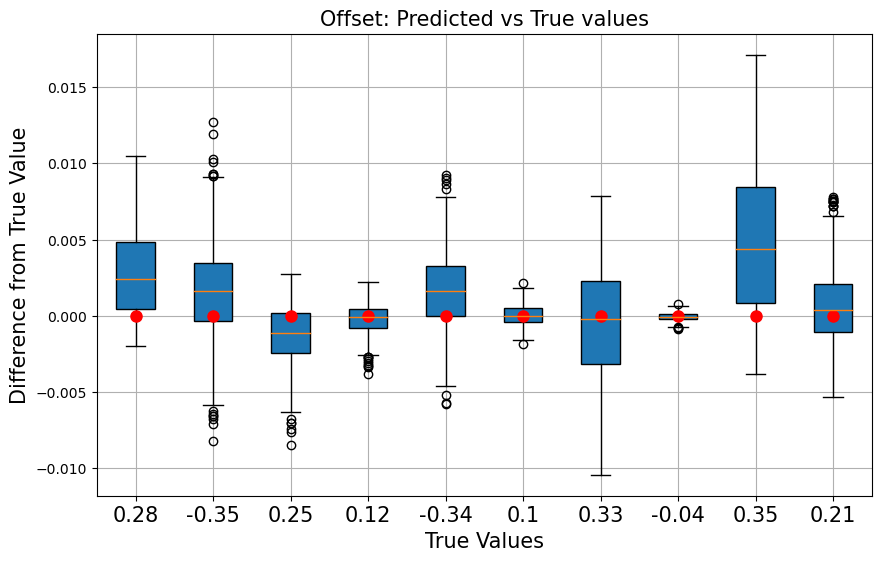

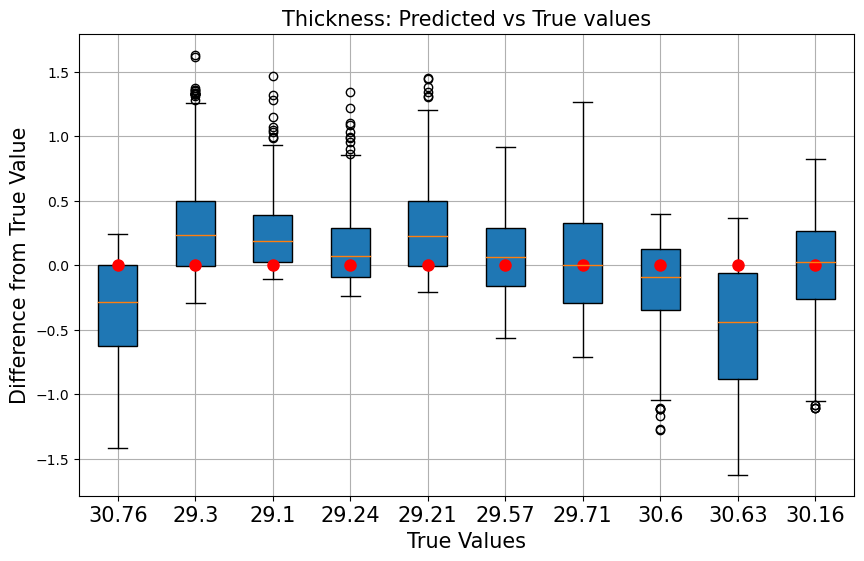

In [ ]:
names = ['Overetch', 'Offset', 'Thickness']
for i in range(3):
    #Create a dataset containing all the same parameter samples 
    plot_data = []
    true_val = []
    for j in range(n):
        true_val.append(X_values[random_samples[j]][i])
        plot_data.append(samples_box[j][i]- true_val[j])

    # Plot box plots
    plt.figure(figsize=(10, 6))
    plt.boxplot(plot_data, patch_artist=True)

    # Plot the mean values
    for idx, mean in enumerate(true_val):
        plt.plot(idx + 1, mean*0, 'ro', label='Mean', markersize=8)

    # Add labels and title
    plt.xlabel('True Values',size= 15)
    plt.ylabel('Difference from True Value',size= 15)
    plt.title(names[i] + ': Predicted vs True values',size= 15)
    plt.xticks(np.arange(1, n + 1), np.round(true_val,2), size= 15)
    plt.grid(True)
    plt.show()

In [4]:
np.mean((2*np.ones((2,3)))**2, axis=0)

array([4., 4., 4.])

In [6]:
for i, n in enumerate([1,10,100]):
    print(i,n)

0 1
1 10
2 100
